In [1]:
import sys
import os
from utils import *

/home/ljaffeux/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-06-03 15:31:05.180243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748957465.305633  123013 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748957465.341915  123013 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 15:31:05.592058: I tensorflow/core/platform/cpu_f

# Load a version of the bias regressor and use it on some dataset

## Scan for versions of BR for the user to choose from 

In [2]:
data_root='../Data'
default_dir = 'Bias_regression'
scan_tuner_versions(default_dir)

Scanning directory: Bias_regression
Found version 'LIAISE_bias' in 'Bias_regression/tuner_results_LIAISE_bias':
    LSTM_CNN: ✅
    Attention: ❌
    Custom: ❌


## User defines version and model to use

In [4]:
version = 'LIAISE_bias'
model = 'LSTM_CNN'# 'LSTM_CNN' or 'Attention'

## Show contextual data within the folder


📄 Configuration loaded from Bias_regression/LIAISE_bias/config.txt:

Key          | Value
-------------|-----------------------------------------
timesteps    | 120
resampling   | '5s'
data         | '['LIAISE']'
INS          | '['IMU1']'
features     | ['AOA_RAD', 'AOS_RAD', 'PITCH', 'ROLL', 'GROUND_SPEED', 'VERTICAL_SPEED', 'TAS']
version      | LIAISE_bias
observations | 
---------------------------------------------------------------------------------
Loading LSTM_CNN model


2025-06-03 16:16:17.051353: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (16, 128)              │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 32)               │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,480 (865.16 KB)

 Trainable params: 73,826 (288.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,654 (576.78 KB)

🖼️ Displaying training plot: Bias_regression/LIAISE_bias/Training_LSTM_CNN.png


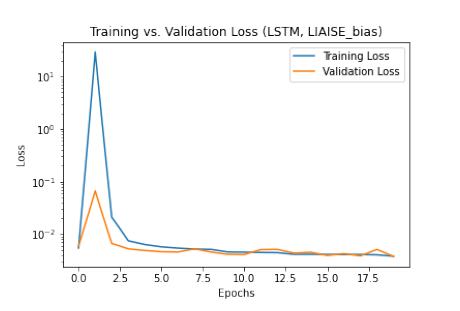

In [5]:
import matplotlib.image as mpimg
# Reading config file
config_path = f'{default_dir}/{version}/config.txt'
if os.path.exists(config_path):
    print(f"\n📄 Configuration loaded from {config_path}:\n")

    config_entries = []
    with open(config_path, "r") as f:
        for line in f:
            line = line.strip()
            if "=" in line:
                key, value = map(str.strip, line.split("=", 1))
                config_entries.append((key, value))

    # Calculate the max width of the key column for alignment
    max_key_len = max(len(k) for k, _ in config_entries)

    # Print header
    print(f"{'Key'.ljust(max_key_len)} | Value")
    print(f"{'-' * max_key_len}-|-{'-' * 40}")

    # Print key-value pairs
    for key, value in config_entries:
        print(f"{key.ljust(max_key_len)} | {value}")

# Store relevant infos for applying the model
timesteps = int(config_entries[0][1])
resampling = config_entries[1][1][1:-1]
features = ast.literal_eval((config_entries[4][1]))

print('---------------------------------------------------------------------------------')
print(f'Loading {model} model')

best_model = keras.saving.load_model(
    f"{default_dir}/{version}/{model}.keras"
)
# Custom loading model
scaler = joblib.load(f'{default_dir}/{version}/scaler_train.pkl')
scalery = joblib.load(f'{default_dir}/{version}/scaler_target.pkl')

best_model.summary()
image_path = f'{default_dir}/{version}/Training_{model}.png'


print(f"🖼️ Displaying training plot: {image_path}")
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [23]:
# Campaign you want to use the model on
campaign = 'LIAISE'
INS = 'IMU1' # unconsequential if not MAESTRO (hard coded)
bias_TS = True # Plot time series by flights
Bias_overview = True # Plots mean biases by flight, explores the dependency of these biases

🔄 Processing data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:05<00:00,  8.17s/it]


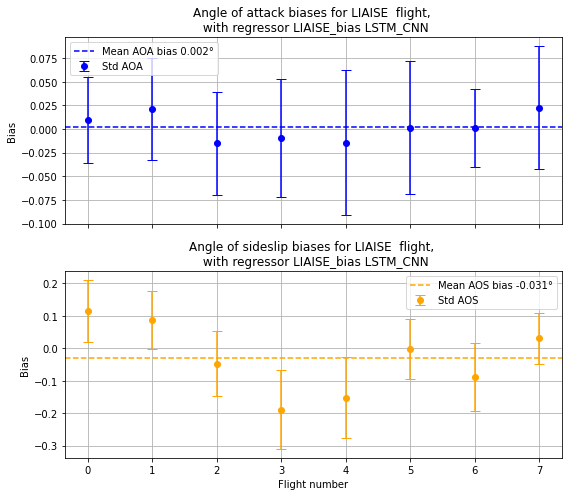

In [24]:
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i : i + timesteps])  # Extract time window
    return np.array(sequences)

mean_bias_E = []
std_bias_E = []
version_dir = f'Bias_regression/{version}'
for INS in ['IMU2']:
    print("🔄 Processing data...")
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    # make plot dir
    plot_dir = f'../Plots/{version}/{model}/{campaign}{INS}'
    os.makedirs(plot_dir ,exist_ok = True)
    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
    
    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue
        
        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue
        if flight_number < 200009 and campaign == 'EUREC4A': # Special condition for EUREC4A
            print(f'Skipping bad EUREC4A flight {flight_number}')
            continue
        yaml_path = os.path.join(segmentation_dir, fname)
    
        # Match raw data folder
        matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                               if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
        
        if not matching_raw_folder:
            print(f"❌ No raw folder found for {campaign} {INS}")
            continue
    
        raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
        # Look for any .nc file containing the flight number
        flight_str = f'{flight_number:02d}'
        nc_candidates = [f for f in os.listdir(raw_folder)
                         if f.endswith('.nc') and flight_str in f]
        
        if not nc_candidates:
            print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
            continue
        
        nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
        df_raw = load_raw_data(nc_path)
        
        if 'GROUND_SPEED' in features:
            df_raw['GROUND_SPEED'] = np.sqrt(df_raw['NORTH_SPEED']**2 + df_raw['EAST_SPEED']**2)
    
        # make df variables consistent
        if 'SIDESLIP_RAD' in df_raw.columns:
            df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
        if 'ALTI_INS' in df_raw.columns:
            df_raw['ALTITUDE'] = df_raw['ALTI_INS']
            
        # Data scaling
        df_resampled = df_raw[features].dropna().resample(resampling).mean().dropna()
        new_data_scaled = scaler.transform(df_resampled.values)
        X_new = create_sequences(new_data_scaled, timesteps)
        predictions = best_model.predict(X_new, verbose = None)
        # Extracting biases
        biases = scalery.inverse_transform(predictions)
        n_features = len(features)
        mean_bias_E.append([np.mean(biases[:, 0]),np.mean(biases[:, 1])])
        std_bias_E.append([np.std(biases[:, 0]),np.std(biases[:, 1])])
        
        if bias_TS : 
            fig, axes = plt.subplots(3, 1, figsize=(14, 6))
    
            
            axes[0].plot(df_resampled.index[timesteps :], biases, label=['aoa_b','aos_b'])
            axes[0].set_xlabel("Time Step")
            axes[0].set_ylabel("Angle of Attack bias")
            axes[0].axhline(np.mean(biases[:, 0]), color='C0', linestyle='--', linewidth=1.5, label=f"Average AoA bias",alpha = 0.5)
            axes[0].axhline(np.mean(biases[:, 1]), color='C1', linestyle='--', linewidth=1.5, label=f"Average AoS bias",alpha = 0.5)
            axes[0].set_title(f"Radome bias regression for {campaign} {INS} flight {flight_number}, \n with regressor {version} {model}")
            axes[0].legend()
    
            # Second subplot for HEADING
            axes[1].plot(df_raw.dropna()['HEADING'], label="Heading")
            axes[1].set_xlabel("Time Step")
            axes[1].set_ylabel("Heading")
            axes[1].legend()
    
            # Third subplot for ALTITUDE
            axes[2].plot(df_raw.dropna()['ALTITUDE'], label="Altitude")
            axes[2].set_xlabel("Time Step")
            axes[2].set_ylabel("Altitude")
            axes[2].legend()
            
            axes[0].grid()
            axes[1].grid()
            axes[2].grid()
            # Adjust layout for better spacing between subplots
            plt.tight_layout()
            # Save the figure with all subplots
            plt.savefig(f'{plot_dir}/Flight{flight_number}_subplots.png')
            plt.close()
            
    if Bias_overview:
        fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
        x = np.arange(0, len(mean_bias_E), 1)
        # First subplot: Legs AOA
        axes[0].errorbar(x, np.array(mean_bias_E)[:, 0], yerr=np.array(std_bias_E)[:, 0], 
                         fmt='o', color='blue', label='Std AOA', capsize=5)
        axes[0].axhline(np.nanmean(np.array(mean_bias_E)[:, 0]), color='blue', linestyle='--', linewidth=1.5, label=f"Mean AOA bias {np.nanmean(np.array(mean_bias_E)[:, 0]):.03f}°")
        axes[0].grid()
        axes[0].set_ylabel("Bias")
        axes[0].legend()
        axes[0].set_title(f"Angle of attack biases for {campaign} {INS} flight, \n with regressor {version} {model}")
        
        # Second subplot: Legs AOS
        axes[1].errorbar(x, np.array(mean_bias_E)[:, 1], yerr=np.array(std_bias_E)[:, 1], 
                         fmt='o', color='orange', label='Std AOS', capsize=5)
        axes[1].axhline(np.nanmean(np.array(mean_bias_E)[:, 1]), color='orange', linestyle='--', linewidth=1.5, label=f"Mean AOS bias {np.nanmean(np.array(mean_bias_E)[:, 1]):.03f}°")
        axes[1].grid()
        axes[1].set_xlabel("Flight number")
        axes[1].set_ylabel("Bias")
        axes[1].legend()
        axes[1].set_title(f"Angle of sideslip biases for {campaign} {INS} flight, \n with regressor {version} {model}")
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.savefig(f'{plot_dir}/Bias_estimations_{model}_{campaign}{INS}.png', dpi=300)
        plt.show()

    if not campaign == 'MAESTRO':
        break

In [22]:
np.array(mean_bias_E[4:])

array([[ 0.06154005, -0.1979652 ],
       [ 0.0983196 ,  0.13000652],
       [ 0.08078172,  0.18835025],
       [ 0.09757464,  0.30838802],
       [ 0.1244017 ,  0.10263739],
       [ 0.08864157,  0.10505999],
       [ 0.10564395,  0.13806124]], dtype=float32)